# Reinforcement Learning for trading

To train a trading agent, we need to create a market environment that provides price and other information, offers trading-related actions, and keeps track of the portfolio to reward the agent accordingly.

## How to Design an OpenAI trading environment

The OpenAI Gym allows for the design, registration, and utilization of environments that adhere to its architecture, as described in its [documentation](https://github.com/openai/gym/tree/master/gym/envs#how-to-create-new-environments-for-gym). The [trading_env.py](trading_env.py) file implements an example that illustrates how to create a class that implements the requisite `step()` and `reset()` methods.

The trading environment consists of three classes that interact to facilitate the agent's activities:
 1. The `DataSource` class loads a time series, generates a few features, and provides the latest observation to the agent at each time step. 
 2. `TradingSimulator` tracks the positions, trades and cost, and the performance. It also implements and records the results of a buy-and-hold benchmark strategy. 
 3. `TradingEnvironment` itself orchestrates the process. 

## A basic trading game

To train the agent, we need to set up a simple game with a limited set of options, a relatively low-dimensional state, and other parameters that can be easily modified and extended.

More specifically, the environment samples a stock price time series for a single ticker using a random start date to simulate a trading period that, by default, contains 252 days, or 1 year. The state contains the (scaled) price and volume, as well as some technical indicators like the percentile ranks of price and volume, a relative strength index (RSI), as well as 5- and 21-day returns. The agent can choose from three actions:

- **Buy**: Invest capital for a long position in the stock
- **Flat**: Hold cash only
- **Sell short**: Take a short position equal to the amount of capital

The environment accounts for trading cost, which is set to 10bps by default. It also deducts a 1bps time cost per period. It tracks the net asset value (NAV) of the agent's portfolio and compares it against the market portfolio (which trades frictionless to raise the bar for the agent).

We use the same DDQN agent and neural network architecture that successfully learned to navigate the Lunar Lander environment. We let exploration continue for 500,000 time steps (~2,000 1yr trading periods) with linear decay of ε to 0.1 and exponential decay at a factor of 0.9999 thereafter.

## Imports & Settings

In [1]:
%matplotlib inline
from pathlib import Path
from collections import deque, namedtuple
from time import time
from random import sample
import numpy as np
from numpy.random import random, randint, seed
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf

import gym
from gym.envs.registration import register

In [2]:
sns.set_style('darkgrid')

### Helper functions

In [3]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:05.2f}'.format(m, s)

In [4]:
def track_results(episode, episode_nav,
                  market_nav, ratio,
                  total,
                  epsilon):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)

    print('{:>4d} | NAV: {:>5.3f} | Market NAV: {:>5.3f} | Delta: {:4.0f} | {} | '
          'eps: {:>6.3f}'.format(episode,
                                  episode_nav,
                                  market_nav,
                                  ratio,
                                  format_time(total),
                                  epsilon))

## Set up Gym Environment

Before using the custom environment, just like we used the Lunar Lander environment, we need to register it:

In [5]:
register(
    id='trading-v0',
    entry_point='trading_env:TradingEnvironment',
    max_episode_steps=1000
)

### Initialize Trading Environment

We can instantiate the environment by using the desired trading costs and ticker:

In [7]:
trading_environment = gym.make('trading-v0')
trading_environment.env.trading_cost_bps = 1e-3
trading_environment.env.time_cost_bps = 1e-4
trading_environment.env.ticker = 'AAPL'
trading_environment.seed(42)

INFO:trading_env:trading_env logger started.
INFO:trading_env:loading data for AAPL...
INFO:trading_env:got data for AAPL...
INFO:trading_env:None


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8596 entries, (1981-05-06 00:00:00, AAPL) to (2018-03-27 00:00:00, AAPL)
Data columns (total 10 columns):
close             8596 non-null float64
volume            8596 non-null float64
returns           8596 non-null float64
close_pct_100     8596 non-null float64
volume_pct_100    8596 non-null float64
close_pct_20      8596 non-null float64
volume_pct_20     8596 non-null float64
return_5          8596 non-null float64
return_21         8596 non-null float64
rsi               8596 non-null float64
dtypes: float64(10)
memory usage: 841.8+ KB


[42]

### Get Environment Params

In [11]:
state_dim = trading_environment.observation_space.shape[0]  # number of dimensions in state
n_actions = trading_environment.action_space.n  # number of actions
max_episode_steps = trading_environment.spec.max_episode_steps  # max number of steps per episode

## Define hyperparameters

In [12]:
gamma=.99,  # discount factor
tau=100  # target network update frequency

### NN Architecture

In [13]:
layers=(256,) * 3  # units per layer
learning_rate=5e-5  # learning rate
l2_reg=1e-6  # L2 regularization

### Experience Replay

In [14]:
replay_capacity=int(1e6)
minibatch_size=5

### $\epsilon$-greedy Policy

In [15]:
epsilon_start=1.0
epsilon_end=0.1
epsilon_linear_steps=5e5
epsilon_exp_decay=.9999

## Create Neural Network

We will use [TensorFlow](https://www.tensorflow.org/) to create our Double Deep Q-Network .

In [ ]:
tf.reset_default_graph()

### Dense Layers

The `create_network` function generates the three dense layers that can be trained and/or reused as required by the Q network and its slower-moving target network:

In [7]:
def create_network(s, layers, trainable, reuse, n_actions=4):
    """Generate Q and target network with same structure"""
    for layer, units in enumerate(layers):
        x = tf.layers.dense(inputs=s if layer == 0 else x,
                            units=units,
                            activation=tf.nn.relu,
                            trainable=trainable,
                            reuse=reuse,
                            name='dense_{}'.format(layer))
    return tf.squeeze(tf.layers.dense(inputs=x,
                                      units=n_actions,
                                      trainable=trainable,
                                      reuse=reuse,
                                      name='output'))

### Placeholders

Key elements of the DDQN's computational graph include placeholder variables for the state, action, and reward sequences:

In [8]:
state = tf.placeholder(dtype=tf.float32, shape=[None, state_dim])  # input to Q network
next_state = tf.placeholder(dtype=tf.float32, shape=[None, state_dim])  # input to target network
action = tf.placeholder(dtype=tf.int32, shape=[None])  # action indices (indices of Q network output)
reward = tf.placeholder(dtype=tf.float32, shape=[None])  # rewards for target computation
not_done = tf.placeholder(dtype=tf.float32, shape=[None])  # indicators for target computation

### Episode Counter

We add a variable to keep track of episodes:

In [ ]:
episode_count = tf.Variable(0.0, trainable=False, name='episode_count')
add_episode = episode_count.assign_add(1)

### Deep Q Networks

We will create two DQNs to predict q values for the current and next state, where we hold the weights for the second network that's fixed when predicting the next state:

In [ ]:
with tf.variable_scope('Q_Network'):
    # Q network applied to current observation
    q_action_values = create_network(state,
                                     layers=layers,
                                     trainable=True,
                                     reuse=False)

    # Q network applied to next_observation
    next_q_action_values = tf.stop_gradient(create_network(next_state,
                                                           layers=layers,
                                                           trainable=False,
                                                           reuse=True))

### Slow-Moving Target Network

In addition, we will create the target network that we update every tau periods:

In [ ]:
with tf.variable_scope('Target_Network', reuse=False):
    target_action_values = tf.stop_gradient(create_network(next_state,
                                                           layers=layers,
                                                           trainable=False,
                                                           reuse=False))

### Collect Variables and Operations

To build TensorFlow's computational graph, we need to collect the relevant variables and operations:

In [ ]:
q_network_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Q_Network')
target_network_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Target_Network')

# update target network weights
update_target_ops = []
for i, target_variable in enumerate(target_network_variables):
    update_target_op = target_variable.assign(q_network_variables[i])
    update_target_ops.append(update_target_op)
update_target_op = tf.group(*update_target_ops, name='update_target')

### Compute Q-Learning updates

The target, yi, and the predicted q value is computed as follows:

In [ ]:
# Q target calculation 
targets = reward + not_done * gamma * tf.gather_nd(target_action_values, tf.stack(
                (tf.range(minibatch_size), tf.cast(tf.argmax(next_q_action_values, axis=1), tf.int32)), axis=1))


# Estimated Q values for (s,a) from experience replay
predicted_q_value = tf.gather_nd(q_action_values,
                                 tf.stack((tf.range(minibatch_size),
                                           action), axis=1))

### Compute Loss Function

Finally, the TD loss function that's used for stochastic gradient descent is the mean squared error (MSE) between the target and prediction:

In [ ]:
losses = tf.squared_difference(targets, predicted_q_value)
loss = tf.reduce_mean(losses)
loss += tf.add_n([tf.nn.l2_loss(var) for var in q_network_variables if 'bias' not in var.name]) * l2_reg * 0.5

### Tensorboard summaries

To view results in [tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard), we need to define summaries:

In [ ]:
summaries = tf.summary.merge([
    tf.summary.scalar('episode', episode_count),
    tf.summary.scalar('loss', loss),
    tf.summary.scalar('max_q_value', tf.reduce_max(predicted_q_value)),
    tf.summary.histogram('loss_hist', losses),
    tf.summary.histogram('q_values', predicted_q_value)])

### Set optimizer

We'll use the [AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer):

In [ ]:
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss,
                                                          global_step=tf.train.create_global_step())

### Initialize TensorFlow session

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


## Run Experiment

### Set parameters

In [19]:
total_steps, max_episodes = 0, 10000
experience = deque(maxlen=replay_capacity)
episode_time, navs, market_navs,diffs, episode_eps = [], [], [], [],[]

### Initialize variables

In [16]:
experience = deque(maxlen=replay_capacity)
episode_time, episode_steps, episode_rewards, episode_eps = [], [], [], []

In [14]:
epsilon = epsilon_start
epsilon_linear_step = (epsilon_start - epsilon_end) / epsilon_linear_steps

### Train Agent

In [23]:
for episode in range(max_episodes):
    episode_start = time()
    episode_reward = 0
    episode_eps.append(epsilon)

    # Initial state
    this_observation = trading_environment.reset()
    for episode_step in range(max_episode_steps):

        # choose action according to epsilon-greedy policy wrt Q

        if random() < epsilon:
            src = 'eps'
            selected_action = randint(n_actions)
        else:
            src = 'q'
            q_s = sess.run(q_action_values,
                           feed_dict={state: this_observation[None]})
            selected_action = np.argmax(q_s)

        next_observation, step_reward, done, _ = trading_environment.step(selected_action)
        episode_reward += step_reward

        # add to replay buffer
        experience.append((this_observation,
                           selected_action,
                           step_reward,
                           next_observation,
                           0.0 if done else 1.0))

        # update the target weights
        if total_steps % tau == 0:
            _ = sess.run(update_target_op)

        # update weights using minibatch of (s,a,r,s') samples from experience
        if len(experience) >= minibatch_size:
            minibatch = map(np.array, zip(
                *sample(experience, minibatch_size)))
            states_batch, action_batch, reward_batch, next_states_batch, done_batch = minibatch

            # do a train_op with required inputs
            feed_dict = {
                state: states_batch,
                action: action_batch,
                reward: reward_batch,
                next_state: next_states_batch,
                not_done: done_batch}
            _ = sess.run([train_op],
                         feed_dict=feed_dict)

        this_observation = next_observation
        total_steps += 1

        # linearly decay epsilon from epsilon_start to epsilon_end for epsilon_linear_steps
        if total_steps < epsilon_linear_steps:
            epsilon -= epsilon_linear_step
        # then exponentially decay every episode
        elif done:
            epsilon *= epsilon_exp_decay

        if done:
            # Increment episode counter
            episode_, _ = sess.run([episode_count, add_episode])
            break

    episode_time.append(time()-episode_start)
    result = trading_environment.env.sim.result()
    final = result.iloc[-1]

    nav = final.nav * (1 + final.strategy_return)
    navs.append(nav)

    market_nav = final.market_nav
    market_navs.append(market_nav)

    diff = nav - market_nav
    diffs.append(diff)
    if episode % 250 == 0:
        track_results(episode,
                      np.mean(navs[-100:]),
                      np.mean(market_navs[-100:]),
                      np.sum([s > 0 for s in diffs[-100:]]),
                      sum(episode_time),
                      epsilon)

    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break

trading_environment.close()

   0 | NAV: 0.534 | Market NAV: 1.836 | Delta:    0 | 00:00.47 | eps:  0.999
 250 | NAV: 0.797 | Market NAV: 1.331 | Delta:   19 | 00:56.60 | eps:  0.886
 500 | NAV: 0.774 | Market NAV: 1.253 | Delta:   23 | 01:55.27 | eps:  0.772
 750 | NAV: 0.801 | Market NAV: 1.431 | Delta:   16 | 02:56.54 | eps:  0.659
1000 | NAV: 0.849 | Market NAV: 1.406 | Delta:   26 | 04:07.49 | eps:  0.545
1250 | NAV: 0.819 | Market NAV: 1.303 | Delta:   13 | 05:19.67 | eps:  0.432
1500 | NAV: 0.974 | Market NAV: 1.297 | Delta:   29 | 06:31.60 | eps:  0.319
1750 | NAV: 0.938 | Market NAV: 1.359 | Delta:   30 | 07:45.69 | eps:  0.205
2000 | NAV: 1.081 | Market NAV: 1.403 | Delta:   25 | 09:02.94 | eps:  0.100
2250 | NAV: 1.132 | Market NAV: 1.492 | Delta:   25 | 10:23.32 | eps:  0.097
2500 | NAV: 1.014 | Market NAV: 1.324 | Delta:   21 | 11:46.05 | eps:  0.095
2750 | NAV: 1.017 | Market NAV: 1.359 | Delta:   21 | 13:11.42 | eps:  0.093
3000 | NAV: 1.089 | Market NAV: 1.275 | Delta:   35 | 14:39.76 | eps:  0.090

### Store Results

In [27]:
results = pd.DataFrame({'episode': list(range(1, episode + 2)),
                        'nav': navs,
                        'market_nav': market_navs,
                        'outperform': diffs})

fn = 'trading_agent_result_no_cost.csv'
results.to_csv(fn, index=False)

### Evaluate Results

In [34]:
results = pd.read_csv('trading_agent_result.csv')
results.columns = ['Episode', 'Agent', 'Market', 'difference']
results = results.set_index('Episode')
results['Strategy Wins (%)'] = (results.difference > 0).rolling(100).sum()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14039 entries, 1 to 14039
Data columns (total 4 columns):
Agent                14039 non-null float64
Market               14039 non-null float64
difference           14039 non-null float64
Strategy Wins (%)    13940 non-null float64
dtypes: float64(4)
memory usage: 548.4 KB


The following diagram shows the rolling average of agent and market returns over 100 periods on the left, and the share of the last 100 periods the agent outperformed the market on the right. It uses AAPL stock data for which there are some 9,000 daily price and volume observations. Training stopped after 14,000 trading periods when the agent beat the market 10 consecutive times.

It shows how the agent's performance improves significantly while exploring at a higher rate over the first ~3,000 periods (that is, years) and approaches a level where it outperforms the market around 40 percent of the time, despite transaction costs. In a few instances, it beats the market about half the time out of 100 periods:

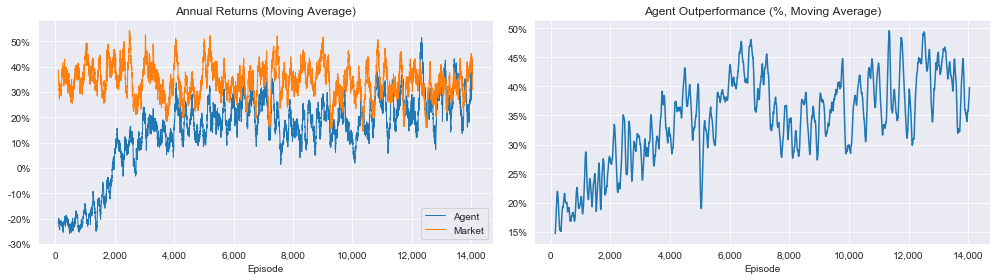

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
(results[['Agent', 'Market']]
 .sub(1)
 .rolling(100)
 .mean()
 .plot(ax=axes[0], 
       title='Annual Returns (Moving Average)', lw=1))
results['Strategy Wins (%)'].div(100).rolling(50).mean().plot(ax=axes[1], title='Agent Outperformance (%, Moving Average)');
for ax in axes:
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
fig.tight_layout()
# fig.savefig('figures/trading_agent', dpi=300)

## Summary

This relatively simple agent uses limited information beyond the latest market data and the reward signal compared to the machine learning models we covered elsewhere in this book. Nonetheless, it learns to make a profit and approach the market (after training on several thousand year's worth of data, which takes around 30 minutes).

Keep in mind that using a single stock also increase the risk of overfitting the data by a lot. You can test your trained agent on new data using the saved model (see the notebook on the Lunar Lander).

In conclusion, we have demonstrated the mechanics of setting up a RL trading environment and experimented with a basic agent that uses a small number of technical indicators. You should try to extend both the environment and the agent so that you can choose from several assets, size their positions, and manage risks.

More specifically, the environment samples a stock price time series for a single ticker from a random start date to simulate a trading period of 252 days, or 1 year (default). The agent has three options, that is, buying (long), short, or exiting its position, and faces a 10bps trading plus a 1bps time cost per period.